In [ ]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

import numpy as np

import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path
sys.path.append('insert_correct_path_here')
sys.path.append('insert_correct_path_here')

Mounted at /content/gdrive


# Use a GPU

In [ ]:
# Use a GPU
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


In [ ]:
import torch.nn.functional as F

from unet_parts import *

# Create Unet model
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    # Forward pass
    def forward(self, x):
        # Down is a Conv layer
        # Up is a Conv.T layer
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
# Retrieve data from correct file

dir='insert_correct_path_here'
train_amp_fname='16kdatatrainamp.npy'
train_amp=np.load(dir+train_amp_fname)
val_amp_fname='16kdatavalamp.npy'
val_amp=np.load(dir+val_amp_fname)
test_amp_fname='16kdatatestamp.npy'
test_amp=np.load(dir+test_amp_fname)

train_phase_fname='16kdatatrainphase.npy'
train_phase=np.load(dir+train_phase_fname)
val_phase_fname='16kdatavalphase.npy'
val_phase=np.load(dir+val_phase_fname)
test_phase_fname='16kdatatestphase.npy'
test_phase=np.load(dir+test_phase_fname)

In [ ]:
# Reshape input data for model
train_amp=train_amp.reshape((train_amp.shape[0],train_amp.shape[1], train_amp.shape[1],train_amp.shape[1]))
val_amp=val_amp.reshape((val_amp.shape[0],train_amp.shape[1], train_amp.shape[1],train_amp.shape[1]))
test_amp=test_amp.reshape((test_amp.shape[0],train_amp.shape[1], train_amp.shape[1],train_amp.shape[1]))

train_phase=train_phase.reshape((train_phase.shape[0],train_phase.shape[1], train_phase.shape[1],train_phase.shape[1]))
val_phase=val_phase.reshape((val_phase.shape[0],train_phase.shape[1], train_phase.shape[1],train_phase.shape[1]))
test_phase=test_phase.reshape((test_phase.shape[0],train_phase.shape[1], train_phase.shape[1],train_phase.shape[1]))

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
# Use the data loader that was made
import torch
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, labels, shifted_amplitude):
        'Initialization'
        self.all_data = torch.from_numpy(shifted_amplitude)
        self.labels = labels

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.all_data)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.all_data[index]

        y = self.labels[index]

        return X, y

In [ ]:
# Define the loss function
# In this case, we use a normalized mean square error loss
def NMSE_Loss(output,target,phase=False):
  #  1 - cos (theta_i - theta_pred_i)
  if phase==True:
    return torch.sum(torch.sum((1.0 - torch.cos(target - output)),dim=(1,2,3)))/len(target)#/torch.sum((1.0 - torch.cos(target)),dim=(1,2,3)))/len(target)
  else:
    return torch.sum(torch.sum(torch.square(output-target),dim=(1,2,3))/torch.sum(torch.square(target),dim=(1,2,3)))/len(target)

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 300,
          'shuffle': True,
          'num_workers': 2}
max_epochs = 100

labels = {}

# Create training and validation datasets using input data and 
# the Dataset class
training_set = Dataset(train_phase, train_amp)
validation = (val_amp, val_phase)
training_generator = torch.utils.data.DataLoader(training_set, **params)

# Padding function used for padding tensors with zeros
def Padit(tensorin):
  padarg=(4,3,4,3)
  tensorin=F.pad(tensorin,padarg,'constant',0)
  return tensorin

# Train function
def train(model, optimizer, validation = None, epochs = 1):
  print_every = 100
  t = 0
  loss_list = []
  val_loss_list = []
  # Loop over epochs
  padarg=(4,3,4,3)
  for epoch in range(epochs):
      # Training
      for local_batch, local_labels in training_generator:
          
          #print('epoch: '+ str(s))
          # Transfer to GPU
          local_batch, local_labels = local_batch.to(device), local_labels.to(device)
          local_batch = local_batch.reshape(local_batch.shape[0], 13 , local_batch.shape[1], local_batch.shape[2])
          local_labels = local_labels.reshape(local_labels.shape[0], 13 , local_labels.shape[1], local_labels.shape[2])
          local_batch= local_batch.to(device=device, dtype=dtype)  # move to device, e.g. GPU
          # this padding is for unet
          local_batch = F.pad(torch.clone(local_batch), padarg, 'constant', 0)
          local_labels = F.pad(torch.clone(local_labels), padarg, 'constant', 0)
          local_labels = local_labels.to(device=device, dtype=torch.long)
          # Model computations
          model.train()
          scores = model(local_batch)
          loss = NMSE_Loss(scores, local_labels, phase=True)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          t += 1
      with torch.no_grad():
        print('epoch: '+ str(epoch))
        print('Training Loss:',loss)
        loss_list.append(loss)
      val_amps, val_phases = validation
      val_amps=Padit(val_amps)
      val_phases=Padit(val_phases)
      val_amps=val_amps.to(device,dtype=dtype)
      val_phases=val_phases.to(device,dtype=dtype)
      model.eval()
      with torch.no_grad():
        val_scores = model(val_amps)
        val_loss = NMSE_Loss(val_scores, val_phases, phase=True)
        print('Validation Loss:', val_loss)
        val_loss_list.append(val_loss)
  return loss_list, val_loss_list
    

In [ ]:
# Now that we've set up the data loader, we can use Unet and find the loss
model = UNet(13,13,bilinear=False).to(device) #input channels, output channels


In [ ]:
# Define optimizer and train model
optimizer = optim.Adam(model.parameters(), lr=1e-5,weight_decay=1e-1)
train_loss, val_loss = train(model, optimizer, torch.tensor(validation), 30)

epoch: 0
Training Loss: tensor(124.6824, device='cuda:0', grad_fn=<DivBackward0>)
Validation Loss: tensor(141.8421, device='cuda:0')
epoch: 1
Training Loss: tensor(78.5693, device='cuda:0', grad_fn=<DivBackward0>)
Validation Loss: tensor(118.0241, device='cuda:0')
epoch: 2
Training Loss: tensor(58.7160, device='cuda:0', grad_fn=<DivBackward0>)
Validation Loss: tensor(94.7183, device='cuda:0')
epoch: 3
Training Loss: tensor(43.6160, device='cuda:0', grad_fn=<DivBackward0>)
Validation Loss: tensor(81.7493, device='cuda:0')
epoch: 4
Training Loss: tensor(37.5763, device='cuda:0', grad_fn=<DivBackward0>)
Validation Loss: tensor(72.7663, device='cuda:0')
epoch: 5
Training Loss: tensor(29.7213, device='cuda:0', grad_fn=<DivBackward0>)
Validation Loss: tensor(66.5040, device='cuda:0')
epoch: 6
Training Loss: tensor(27.1887, device='cuda:0', grad_fn=<DivBackward0>)
Validation Loss: tensor(61.6480, device='cuda:0')
epoch: 7
Training Loss: tensor(22.8303, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
# Finding test loss
model.eval()
test_amp = torch.tensor(test_amp)
test_phase = torch.tensor(test_phase)
test_amps=Padit(test_amp)
test_phases=Padit(test_phase)
test_amps= test_amps.to(device,dtype=dtype)
test_phases=test_phases.to(device,dtype=dtype)

test_scores = model(test_amps)
test_loss = NMSE_Loss(test_scores, test_phases, phase=True)
print('Test Loss:', test_loss)


Test Loss: tensor(35.9444, device='cuda:0', grad_fn=<DivBackward0>)


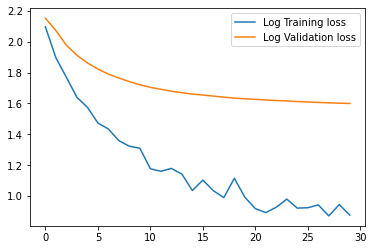

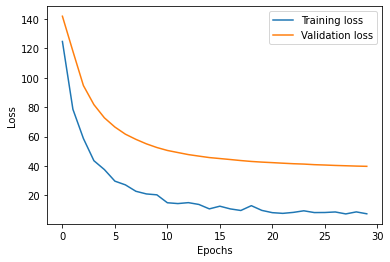

In [ ]:
# Plot the loss function for training and validation sets

log_train_loss = np.log10(train_loss)
log_val_loss = np.log10(val_loss)
import matplotlib.pyplot as plt
plt.plot(log_train_loss,  label = 'Log Training loss')
plt.plot(log_val_loss,  label = 'Log Validation loss')
plt.legend()
plt.show()
plt.plot(train_loss, label = 'Training loss')
plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



tensor(35.2698, dtype=torch.float64)


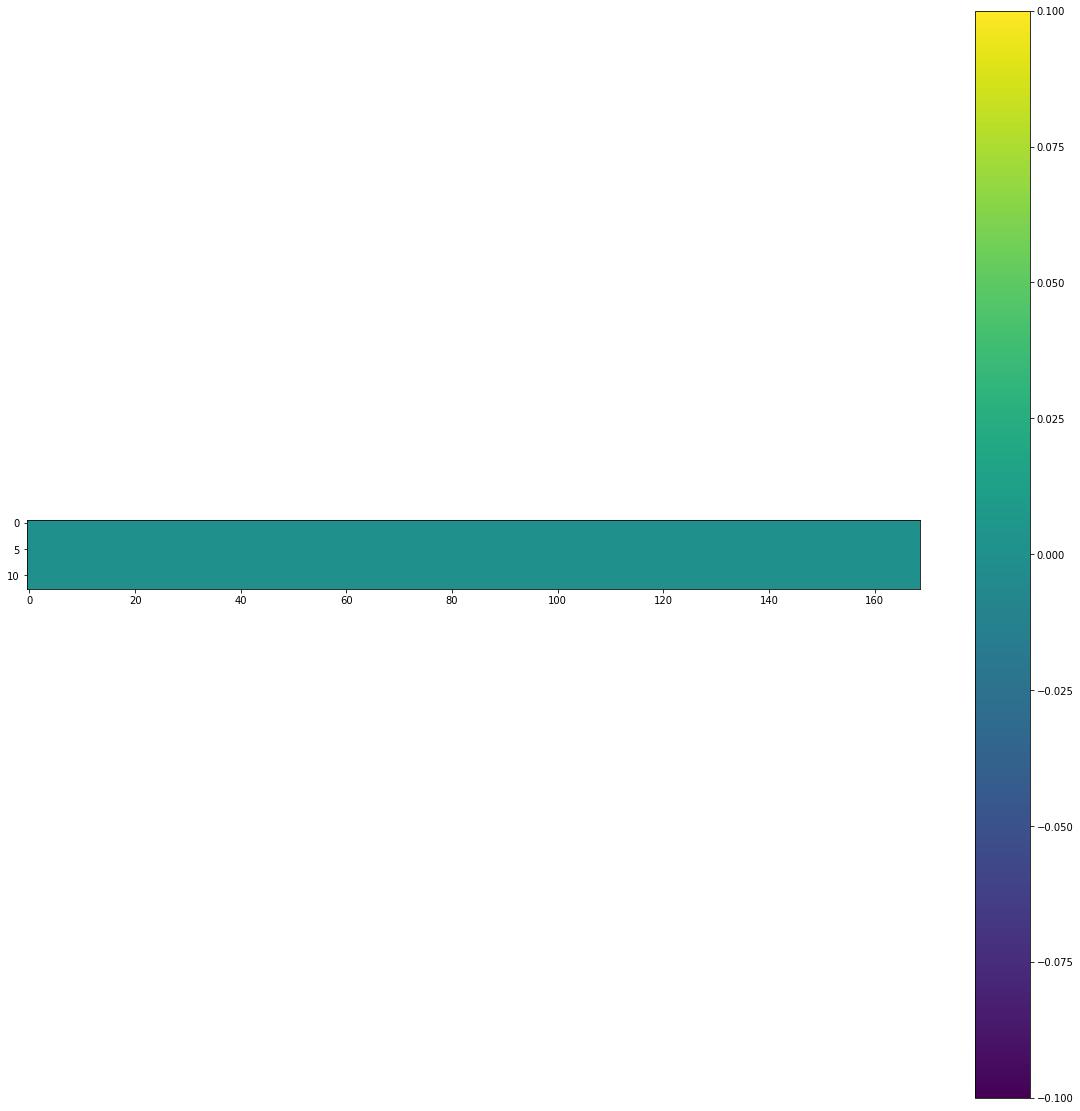

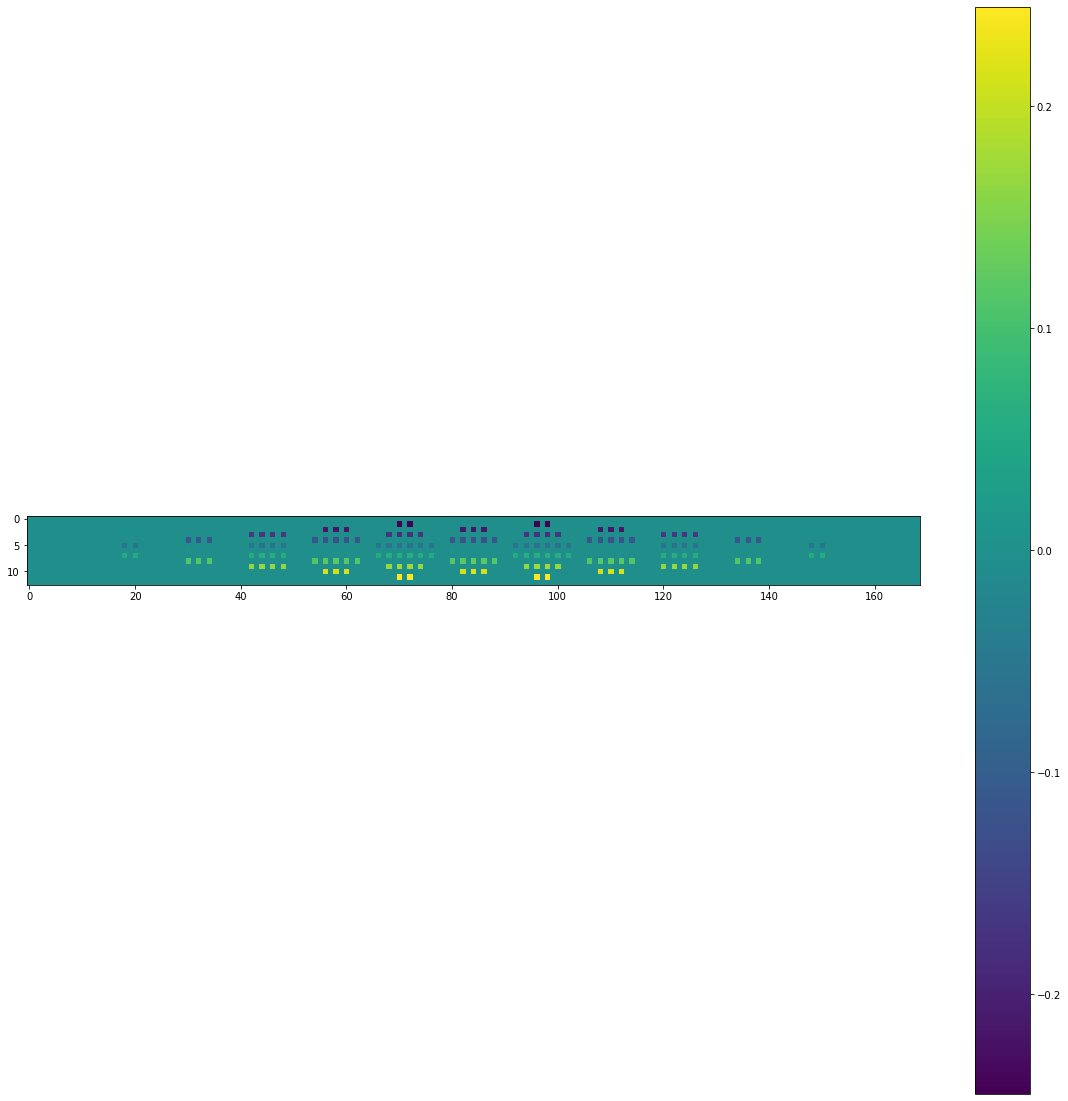

In [ ]:
# Qualitative evaluation of data

import plotly.graph_objects as go
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
def make3dScatterpoints(nmax,nmin=0,includezero=False):
    scattergrid=[]
    for x in range(nmin,nmax+1,1):
        for y in range(nmin,nmax+1,1):
            for z in range(nmin,nmax+1,1):
                if not (((x==0) and (y==0) and (z==0)) and not includezero ):
                    scattergrid.append([x,y,z])
    return scattergrid
def structFactImagetoFs(SFImage,Nmin=-6,Nmax=6):
  hkls=[]
  Fs=[]
  for x in range(SFImage.shape[0]):
    for y in range(SFImage.shape[1]):
      hkl=[0,0,0]
      hkl[0]=int(x)
      hkl[1]=int(y % (Nmax-Nmin+1))
      hkl[2]=int(y / (Nmax-Nmin+1))
      hkls.append(hkl)
      Fs.append(SFImage[x,y])
  hkls=np.array(hkls)-Nmax
  return hkls,Fs
def reconstruct3(structFactImage,densitythresh=.2):
    # Fhkls=np.array(readhkls())
    #xyzs=generatexyzs():#generatexyzs as a row vector 3 by n
    xyzs=np.array(make3dScatterpoints(24,0,includezero=True)).T/(24)
    print(xyzs.shape)
    #hkls=generatehkls():#generate hkls as a column vector n by 3
    # hkls=np.vstack(Fhkls[:,0])#.astype(float)#reshape(len(Fhkls),3)
    hkls,Fs=structFactImagetoFs(structFactImage,Nmin=-6,Nmax=6)
    print(hkls)
    print(hkls.shape)
    print(xyzs)
    print(xyzs.shape)
    qrmat=hkls@xyzs
    print(qrmat)
    qremat=np.e**(2*np.pi*1j*qrmat)#perform elementwise exponential
    qremat=qremat.T#transpose for F multiplication
    #Fhkls=generateFhkls()#get list of Fs in same order as hkls
    #Fs=Fhkls[:,1]
    # Fs=np.abs(Fhkls[:,1])
    Fs=np.diag(Fs)
    Fqremat=qremat@Fs#now we should have all the structure factors with appropriate exponentials
    densitys=Fqremat@np.ones(len(Fqremat[0]))#we sum each row by multiplying by a vector of ones(seems to be faster than numpy.sum)
    print(densitys)
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    densitys=np.abs(densitys)
    # xyzs=np.abs(xyzs[:,densitys>(densitythresh*np.amax(densitys))]-1)
    X=xyzs[0,:]
    Y=xyzs[1,:]
    Z=xyzs[2,:]

    #density_plot=densitys[densitys>(densitythresh*np.amax(densitys))]
    #values=density_plot
    values=densitys

    print(values)
    print('val',values.shape)
    print('X',X.shape)
    # ax.scatter(xyzs[0,:],xyzs[1,:],xyzs[2,:],c=densitys[densitys>(.5*np.amax(densitys))],alpha=.3)
    # ax.set_xlabel('a axis (lattice constant)')
    # ax.set_ylabel('b axis (lattice constant)')
    # ax.set_zlabel('c axis (lattice constant)')
    # ax.set_title('Charge Density Reconstruction (Number of peaks used: '+str(len(Fs))+' )')
    fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    # isomin=0.1,
    # isomax=0.8,
    opacity=0.5, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
    fig.show()#.show()
    # return fig,ax
def getDensity(structFactImage,normalize=True):
  # Fhkls=np.array(readhkls())
    #xyzs=generatexyzs():#generatexyzs as a row vector 3 by n
    xyzs=np.array(make3dScatterpoints(24,0,includezero=True)).T/(24)
    print(xyzs.shape)
    #hkls=generatehkls():#generate hkls as a column vector n by 3
    # hkls=np.vstack(Fhkls[:,0])#.astype(float)#reshape(len(Fhkls),3)
    hkls,Fs=structFactImagetoFs(structFactImage,Nmin=-6,Nmax=6)
    print(hkls)
    print(hkls.shape)
    print(xyzs)
    print(xyzs.shape)
    qrmat=hkls@xyzs
    print(qrmat)
    qremat=np.e**(2*np.pi*1j*qrmat)#perform elementwise exponential
    qremat=qremat.T#transpose for F multiplication
    #Fhkls=generateFhkls()#get list of Fs in same order as hkls
    #Fs=Fhkls[:,1]
    # Fs=np.abs(Fhkls[:,1])
    Fs=np.diag(Fs)
    Fqremat=qremat@Fs#now we should have all the structure factors with appropriate exponentials
    densitys=Fqremat@np.ones(len(Fqremat[0]))#we sum each row by multiplying by a vector of ones(seems to be faster than numpy.sum)
    print(densitys)
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    #densitys=np.abs(densitys)
    if normalize:
      densitys=densitys/np.amax(densitys)

    return densitys
def plotDensity(densitys):
    xyzs=np.array(make3dScatterpoints(24,0,includezero=True)).T/(24)
    X=xyzs[0,:]
    Y=xyzs[1,:]
    Z=xyzs[2,:]

    #density_plot=densitys[densitys>(densitythresh*np.amax(densitys))]
    #values=density_plot
    values=np.abs(densitys)

    print(values)
    print('val',values.shape)
    print('X',X.shape)
    # ax.scatter(xyzs[0,:],xyzs[1,:],xyzs[2,:],c=densitys[densitys>(.5*np.amax(densitys))],alpha=.3)
    # ax.set_xlabel('a axis (lattice constant)')
    # ax.set_ylabel('b axis (lattice constant)')
    # ax.set_zlabel('c axis (lattice constant)')
    # ax.set_title('Charge Density Reconstruction (Number of peaks used: '+str(len(Fs))+' )')
    fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    # isomin=0.1,
    # isomax=0.8,
    opacity=0.5, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
    fig.show()#.show()

def getDensityDifference(Image1,Image2):
  density1=getDensity(Image1)
  density2=getDensity(Image2)
  densitydiff=np.abs(density1)-np.abs(density2)
  plotDensity(densitydiff)

     

def unpadit(tensorin):
  padarg=(4,3,4,3)
  tensorin=tensorin[:,:,4:-3,4:-3]
  return tensorin
model.eval()
import matplotlib.pyplot as plt
test_in=Padit(torch.tensor(test_amp).to(device,dtype=dtype))
test_phase_out=model(test_in)
test_out=torch.tensor(test_in)*np.e**(1j*test_phase_out)
print(NMSE_Loss(unpadit(test_phase_out.cpu().detach()), torch.tensor(test_phase), phase=True))
test_out=unpadit(test_out)
recon_test=test_out[1005].cpu().detach().numpy().reshape(13,169)
recon_test=np.abs(recon_test)
ref_test=test_amp*np.e**(1j*test_phase)
ref_test=ref_test[1005].reshape(13,169)
plt.imshow(np.angle(recon_test))
plt.colorbar()
plt.show()
plt.imshow(np.angle(ref_test))
plt.colorbar()
plt.show()



In [ ]:
reconstruct3(ref_test)

(3, 15625)
[[-6 -6 -6]
 [-6 -5 -6]
 [-6 -4 -6]
 ...
 [ 6  4  6]
 [ 6  5  6]
 [ 6  6  6]]
(2197, 3)
[[0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.04166667 0.08333333 ... 0.91666667 0.95833333 1.        ]]
(3, 15625)
[[  0.    -0.25  -0.5  ... -17.5  -17.75 -18.  ]
 [  0.    -0.25  -0.5  ... -16.5  -16.75 -17.  ]
 [  0.    -0.25  -0.5  ... -15.5  -15.75 -16.  ]
 ...
 [  0.     0.25   0.5  ...  15.5   15.75  16.  ]
 [  0.     0.25   0.5  ...  16.5   16.75  17.  ]
 [  0.     0.25   0.5  ...  17.5   17.75  18.  ]]
[8454.66192364+0.00000000e+00j 6996.39869151+0.00000000e+00j
 3722.77864798-1.98951966e-13j ... 3722.77864798+0.00000000e+00j
 6996.39869151-1.13686838e-13j 8454.66192364+0.00000000e+00j]
[8454.66192364 6996.39869151 3722.77864798 ... 3722.77864798 6996.39869151
 8454.66192364]
val (15625,)
X (15625,)


In [ ]:
reconstruct3(recon_test)

(3, 15625)
[[-6 -6 -6]
 [-6 -5 -6]
 [-6 -4 -6]
 ...
 [ 6  4  6]
 [ 6  5  6]
 [ 6  6  6]]
(2197, 3)
[[0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.04166667 0.08333333 ... 0.91666667 0.95833333 1.        ]]
(3, 15625)
[[  0.    -0.25  -0.5  ... -17.5  -17.75 -18.  ]
 [  0.    -0.25  -0.5  ... -16.5  -16.75 -17.  ]
 [  0.    -0.25  -0.5  ... -15.5  -15.75 -16.  ]
 ...
 [  0.     0.25   0.5  ...  15.5   15.75  16.  ]
 [  0.     0.25   0.5  ...  16.5   16.75  17.  ]
 [  0.     0.25   0.5  ...  17.5   17.75  18.  ]]
[8520.63563538+0.00000000e+00j 7053.94244309+9.14220985e-06j
 3759.85384789+2.28147974e-06j ... 3759.85384789-2.28147979e-06j
 7053.94244309-9.14220994e-06j 8520.63563538-1.40149700e-20j]
[8520.63563538 7053.94244309 3759.85384789 ... 3759.85384789 7053.94244309
 8520.63563538]
val (15625,)
X (15625,)


In [ ]:
# reconstruct3(recon_test)
getDensityDifference(recon_test,ref_test)


(3, 15625)
[[-6 -6 -6]
 [-6 -5 -6]
 [-6 -4 -6]
 ...
 [ 6  4  6]
 [ 6  5  6]
 [ 6  6  6]]
(2197, 3)
[[0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.04166667 0.08333333 ... 0.91666667 0.95833333 1.        ]]
(3, 15625)
[[  0.    -0.25  -0.5  ... -17.5  -17.75 -18.  ]
 [  0.    -0.25  -0.5  ... -16.5  -16.75 -17.  ]
 [  0.    -0.25  -0.5  ... -15.5  -15.75 -16.  ]
 ...
 [  0.     0.25   0.5  ...  15.5   15.75  16.  ]
 [  0.     0.25   0.5  ...  16.5   16.75  17.  ]
 [  0.     0.25   0.5  ...  17.5   17.75  18.  ]]
[8520.63563538+0.00000000e+00j 7053.94244309+9.14220985e-06j
 3759.85384789+2.28147974e-06j ... 3759.85384789-2.28147979e-06j
 7053.94244309-9.14220994e-06j 8520.63563538-1.40149700e-20j]
(3, 15625)
[[-6 -6 -6]
 [-6 -5 -6]
 [-6 -4 -6]
 ...
 [ 6  4  6]
 [ 6  5  6]
 [ 6  6  6]]
(2197, 3)
[[0.         0.         0.         ... 1.         1.         1.        ]
 [0.      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



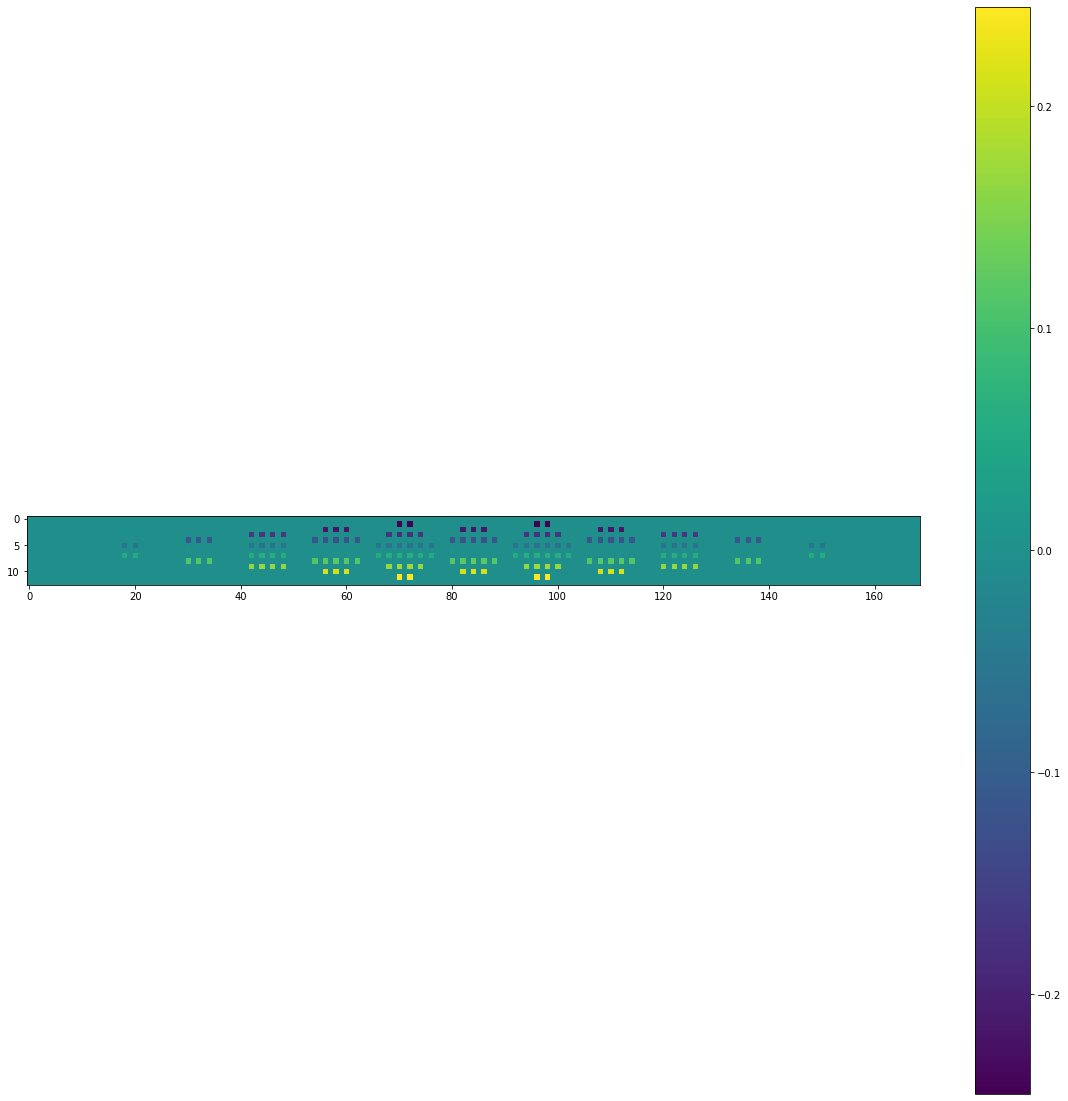

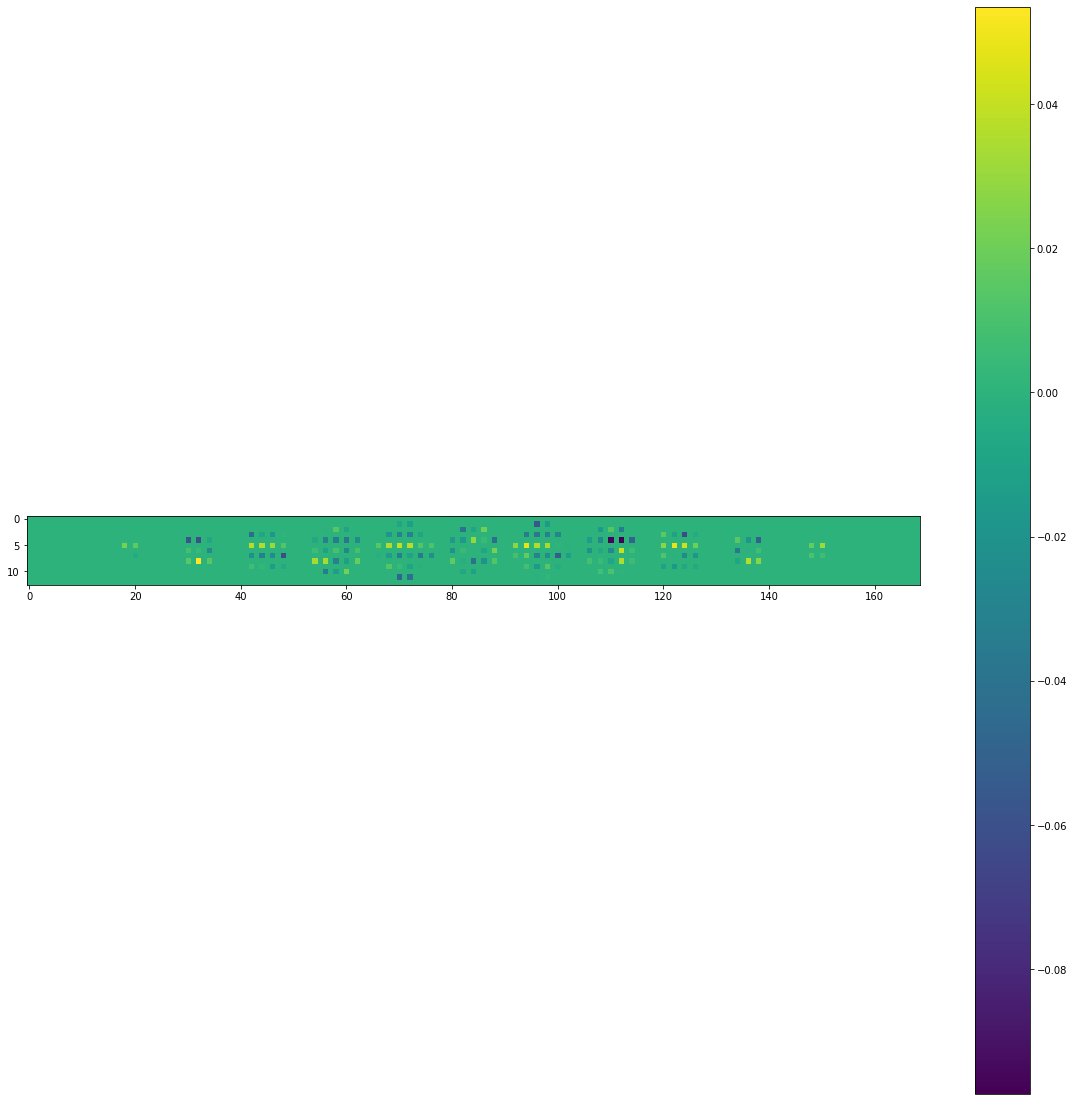

In [ ]:
model.eval()
import matplotlib.pyplot as plt
test_in=Padit(torch.tensor(test_amp).to(device,dtype=dtype))
test_phase_out=model(test_in)
test_out=torch.tensor(test_in)*np.e**(1j*test_phase_out)

test_out=unpadit(test_out)
recon_test=test_out[1005].cpu().detach().numpy().reshape(13,169)
recon_test=recon_test
ref_test=test_amp*np.e**(1j*test_phase)
ref_test=ref_test[1005].reshape(13,169)
plt.imshow(np.angle(ref_test))
plt.colorbar()
plt.show()
plt.imshow(np.angle(recon_test))
plt.colorbar()
plt.show()

In [ ]:
reconstruct3(recon_test)

(3, 15625)
[[-6 -6 -6]
 [-6 -5 -6]
 [-6 -4 -6]
 ...
 [ 6  4  6]
 [ 6  5  6]
 [ 6  6  6]]
(2197, 3)
[[0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.04166667 0.08333333 ... 0.91666667 0.95833333 1.        ]]
(3, 15625)
[[  0.    -0.25  -0.5  ... -17.5  -17.75 -18.  ]
 [  0.    -0.25  -0.5  ... -16.5  -16.75 -17.  ]
 [  0.    -0.25  -0.5  ... -15.5  -15.75 -16.  ]
 ...
 [  0.     0.25   0.5  ...  15.5   15.75  16.  ]
 [  0.     0.25   0.5  ...  16.5   16.75  17.  ]
 [  0.     0.25   0.5  ...  17.5   17.75  18.  ]]
[8517.30432892-41.59175303j 7048.52794016-38.96109606j
 3757.38537341-29.19556203j ... 3759.53717163-28.39241928j
 7053.858423  -38.56381242j 8517.30432892-41.59175303j]
[8517.40587887 7048.63561905 3757.49879909 ... 3759.64438136 7053.9638374
 8517.40587887]
val (15625,)
X (15625,)


In [ ]:
getDensityDifference(recon_test,ref_test)

(3, 15625)
[[-6 -6 -6]
 [-6 -5 -6]
 [-6 -4 -6]
 ...
 [ 6  4  6]
 [ 6  5  6]
 [ 6  6  6]]
(2197, 3)
[[0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.04166667 0.08333333 ... 0.91666667 0.95833333 1.        ]]
(3, 15625)
[[  0.    -0.25  -0.5  ... -17.5  -17.75 -18.  ]
 [  0.    -0.25  -0.5  ... -16.5  -16.75 -17.  ]
 [  0.    -0.25  -0.5  ... -15.5  -15.75 -16.  ]
 ...
 [  0.     0.25   0.5  ...  15.5   15.75  16.  ]
 [  0.     0.25   0.5  ...  16.5   16.75  17.  ]
 [  0.     0.25   0.5  ...  17.5   17.75  18.  ]]
[8517.30432892-41.59175303j 7048.52794016-38.96109606j
 3757.38537341-29.19556203j ... 3759.53717163-28.39241928j
 7053.858423  -38.56381242j 8517.30432892-41.59175303j]
(3, 15625)
[[-6 -6 -6]
 [-6 -5 -6]
 [-6 -4 -6]
 ...
 [ 6  4  6]
 [ 6  5  6]
 [ 6  6  6]]
(2197, 3)
[[0.         0.         0.         ... 1.         1.         1.        ]
 [0.         0.         0.  